In [1]:
# Parameters
NODE_SIZES = [200, 500]  # number of nodes
ER_PS = [0.02, 0.05]    # ER: edge probability
BA_MS = [3, 5]       # BA: edges to attach per new node
WS_K = 4
WS_BETAS = [0.1, 0.3]  # WS: rewiring probability
N_RUNS = 50     # how many runs to average per curve

In [2]:
# Import modules
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# make the plots look nice
plt.rcParams["figure.figsize"] = (6, 4)

Nodes: 100, Edges: 224


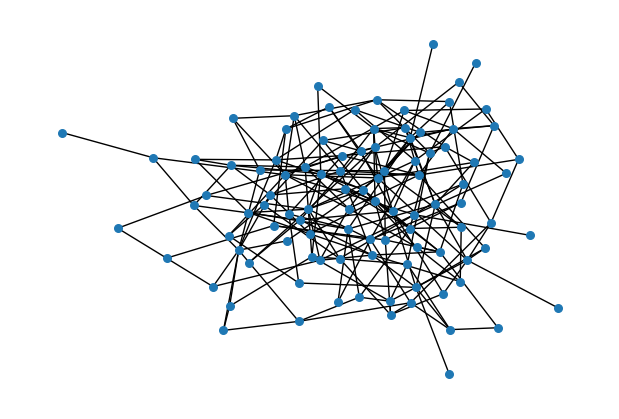

In [3]:
# Generate a sample graph
# Erdos-Renyi graph: n=100 nodes, edge probability=0.05
G = nx.erdos_renyi_graph(100, 0.05, seed=42)
print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
nx.draw(G, node_size=30, with_labels=False)
plt.show()

In [4]:
# Define functions

import random

def largest_component_size(G):
    """Returns the size of the largest connected component as a fraction of nodes"""
    if G.number_of_nodes() == 0:
        return 0
    return len(max(nx.connected_components(G), key=len)) / G.number_of_nodes()

def simulate_removal(G, strategy="random"):
    """Simulates node removals and tracks the fraction of nodes in the largest 
    connected component after each removal.

    G: networkx.Graph
    strategy: "random" or "degree" 
    
    Returns a list of the largest component fractions after each removal"""
   
    # copy graph to preserve original
    H = G.copy()
    N = H.number_of_nodes()
    collapse_curve = []

    if strategy == "random":
        nodes_to_remove = list(H.nodes())
        random.shuffle(nodes_to_remove)
    elif strategy == "degree":
        # sorts nodes by degree decreasing
        nodes_to_remove = sorted(H.nodes(), key=lambda x: H.degree(x), reverse=True)
    else:
        raise ValueError("Unknown strategy: choose 'random' or 'degree'")

    for i, node in enumerate(nodes_to_remove):
        H.remove_node(node)
        if len(H) > 0:
            largest_cc = max(nx.connected_components(H), key=len)
            frac = len(largest_cc) / N
        else:
            frac = 0
        collapse_curve.append(frac)

    return collapse_curve

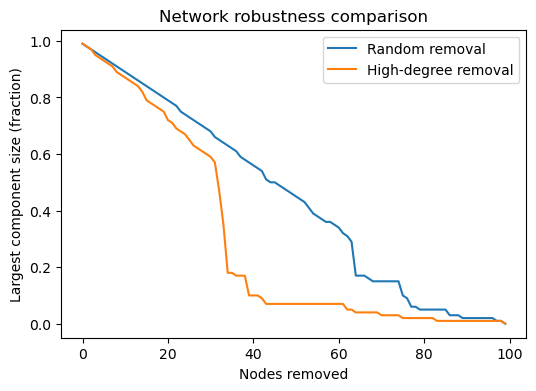

In [5]:
# Test random vs degree-based removal
random_curve = simulate_removal(G, strategy="random")
degree_curve = simulate_removal(G, strategy="degree")

plt.plot(random_curve, label="Random removal")
plt.plot(degree_curve, label="High-degree removal")
plt.xlabel("Nodes removed")
plt.ylabel("Largest component size (fraction)")
plt.legend()
plt.title("Network robustness comparison")
plt.show()

In [6]:
# Add graph generaters with new graph types

def er_graph(n, p, seed=None):
    return nx.erdos_renyi_graph(n=n, p=p, seed=seed)

def ba_graph(n, m, seed=None):
    return nx.barabasi_albert_graph(n=n, m=m, seed=seed)

def ws_graph(n, k, p, seed=None):
    return nx.watts_strogatz_graph(n=n, k=k, p=p, seed=seed)


In [7]:
# Repeat experiments for averages
def average_collapse_curve(generator_func, gen_params, strategy="random", n_runs=100):
    """Runs multiple simulations and returns the average collapse curve and std"""
    all_curves = []
    for _ in range(n_runs):
        G = generator_func(**gen_params)
        curve = simulate_removal(G, strategy=strategy)
        all_curves.append(curve)
    # pad shorter curves with zeros
    max_len = max(len(c) for c in all_curves)
    padded = [c + [0]*(max_len - len(c)) for c in all_curves]
    arr = np.array(padded)
    mean = arr.mean(axis=0)
    std = arr.std(axis=0)
    return mean, std

In [8]:
# Compare network robustness between models

experiments = [
    ("ER", nx.erdos_renyi_graph, {"n": 200, "p": 0.05, "seed": None}),
    ("BA", nx.barabasi_albert_graph, {"n": 200, "m": 3, "seed": None}),
    ("WS", nx.watts_strogatz_graph, {"n": 200, "k": 4, "p": 0.1, "seed": None})
]

strategies = ["random", "degree"]

results = {}

for name, gen_func, params in experiments:
    for strat in strategies:
        mean, std = average_collapse_curve(gen_func, params, strategy=strat, n_runs=50)
        results[(name, strat)] = (mean, std)

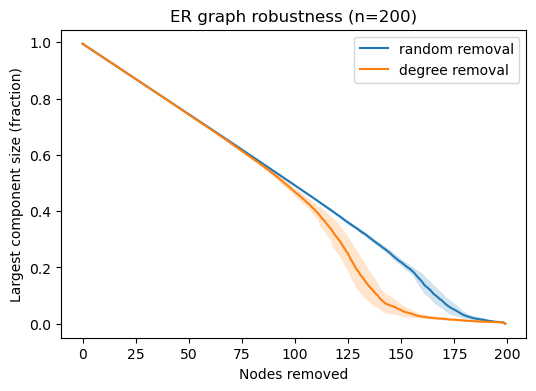

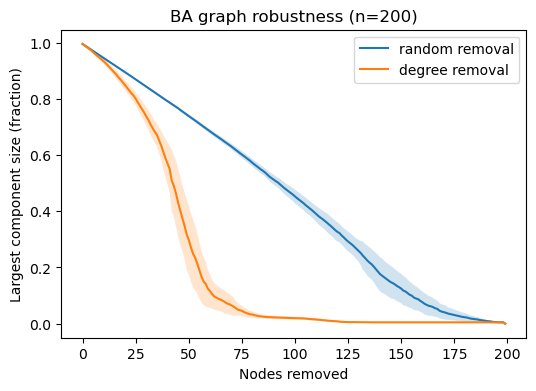

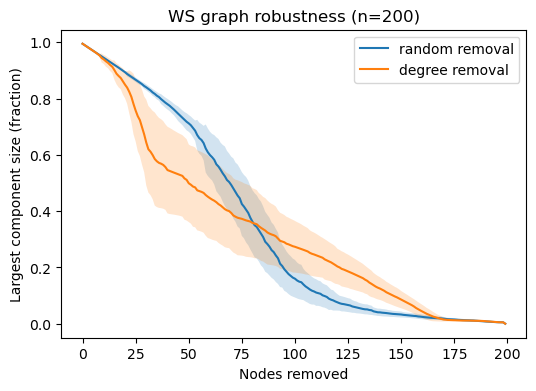

In [9]:
# Compare plots by model
for name, _, _ in experiments:
    plt.figure()
    for strat in strategies:
        mean, std = results[(name, strat)]
        x=np.arange(len(mean))
        plt.plot(x, mean, label=f"{strat} removal")
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"{name} graph robustness (n=200)")
    plt.legend()
    plt.show()

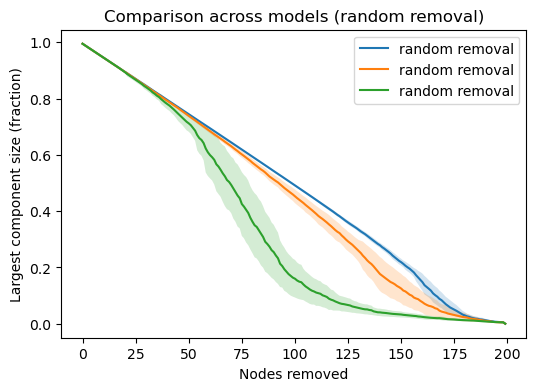

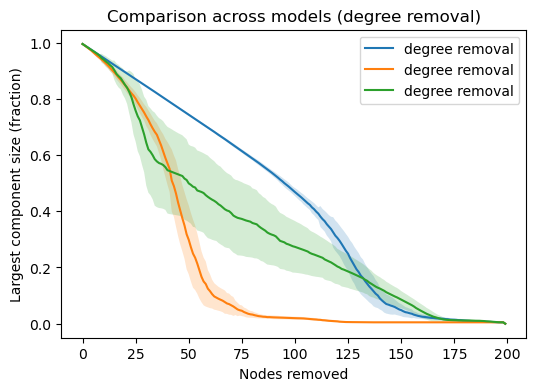

In [10]:
# Compare plots by strategy
for strat in strategies:
    plt.figure()
    for name, _, _ in experiments:
        mean, std = results[(name, strat)]
        x=np.arange(len(mean))
        plt.plot(x, mean, label=f"{strat} removal")
        plt.fill_between(x, mean - std, mean + std, alpha=0.2)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    plt.show()

In [11]:
from sklearn.metrics import auc

# Function to compute robustness score (AUC)
def robustness_score(curve):
    """ curve: list of largest component fractions as nodes are removed. returns
    normalized area under the curve (0-1) """
    x = np.linspace(0, 1, len(curve))  # fraction of nodes removed
    score = auc(x, curve)
    return score / 1.0

In [12]:
import pandas as pd

# Compute robustness scores for all models and strategies with all parameters
batch_results = []

for n in NODE_SIZES:
    for p in ER_PS:
        for strat in strategies:
            mean, std = average_collapse_curve(er_graph, {"n": n, "p": p, "seed": None}, strategy=strat, n_runs=N_RUNS)
            score = robustness_score(mean)
            batch_results.append(["ER", strat, n, p, None, None, score])
    for m in BA_MS:
        for strat in strategies:
            mean, std = average_collapse_curve(ba_graph, {"n": n, "m": m, "seed": None}, strategy=strat, n_runs=N_RUNS)
            score = robustness_score(mean)
            batch_results.append(["BA", strat, n, None, m, None, score])
    for beta in WS_BETAS:
        for strat in strategies:
            mean, std = average_collapse_curve(ws_graph, {"n": n, "k": 4, "p": beta, "seed": None}, strategy=strat, n_runs=N_RUNS)
            score = robustness_score(mean)
            batch_results.append(["WS", strat, n, None, None, beta, score])

In [13]:
import os

# Create results directory
os.makedirs("results", exist_ok=True)

In [17]:
# Save strategy and model comparisons
for name, _, _ in experiments:
    plt.figure(figsize=(6, 4))
    for strat in strategies:
        curve = results[(name, strat)]
        plt.plot(curve, label=strat)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"{name} robustness (N={NODE_SIZES[0]})")
    plt.legend()
    filename = f"results/{name}_N{NODE_SIZES[0]}_robustness.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

for strat in strategies:
    plt.figure(figsize=(6, 4))
    for name, _, _ in experiments:
        curve = results[(name, strat)]
        plt.plot(curve, label=name)
    plt.xlabel("Nodes removed")
    plt.ylabel("Largest component size (fraction)")
    plt.title(f"Comparison across models ({strat} removal)")
    plt.legend()
    filename = f"results/comparison_{strat}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

In [18]:
# Save robustness scores
df_batch = pd.DataFrame(batch_results, columns=[
    "Model", "Strategy", "N", "ER_p", "BA_m", "WS_beta", "RobustnessScore"
])

df_batch.to_csv("results/batch_results.csv", index=False)
df_batch

,Model,Strategy,N,ER_p,BA_m,WS_beta,RobustnessScore
0,ER,random,200,0.02,NaN,NaN,0.404421
1,ER,degree,200,0.02,NaN,NaN,0.251050
2,ER,random,200,0.05,NaN,NaN,0.482737
3,ER,degree,200,0.05,NaN,NaN,0.439165
4,BA,random,200,NaN,3.0,NaN,0.456631
5,BA,degree,200,NaN,3.0,NaN,0.207944
6,BA,random,200,NaN,5.0,NaN,0.479011
7,BA,degree,200,NaN,5.0,NaN,0.323007
8,WS,random,200,NaN,NaN,0.1,0.342608
9,WS,degree,200,NaN,NaN,0.1,0.331780


In [19]:
# Plot robustness vs. parameters

def plot_param_effect(df, model, param, param_label):
    plt.figure(figsize=(6, 4))
    sub=df[df['Model'] == model]
    for strat in strategies:
        strat_data = sub[sub["Strategy"] == strat]
        plt.plot(
            strat_data[param],
            strat_data["RobustnessScore"],
            marker='o',
            label=strat
        )
    plt.xlabel(param_label)
    plt.ylabel("Robustness Score")
    plt.title(f"{model} robustness vs {param_label}")
    plt.legend()
    filename = f"results/{model}_{param}.png"
    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.close()

plot_param_effect(df_batch, "ER", "ER_p", "Edge probability p")

plot_param_effect(df_batch, "BA", "BA_m", "Number of edges m")

plot_param_effect(df_batch, "WS", "WS_beta", "Rewiring probability β")

In [20]:
# Use seaborn to create heatmap function

import seaborn as sns

def plot_heatmap(df, model, param, param_label):
    """ df, DataFrame of results; model: "ER", "BA", or "WS"; param: column 
    name ("ER_p", "BA_m", or "WS_beta"); param_label: pretty label for plot"""
    sub=df[df['Model'] == model]
    for strat in strategies:
        pivot = sub[sub["Strategy"] == strat].pivot_table(
            values="RobustnessScore",
            index="N",
            columns=param
        )
        plt.figure(figsize=(6, 4))
        sns.heatmap(
            pivot,
            annot=True, fmt=".2f", cmap="viridis",
            cbar_kws={'label': 'Robustness Score'}
        )
        plt.title(f"{model} ({strat} removal)\nRobustness vs N and {param_label}")
        plt.xlabel(param_label)
        plt.ylabel("Network size N")
        filename = f"results/{model}_{strat}_{param}_heatmap.png"
        plt.savefig(filename, dpi=300, bbox_inches="tight")
        plt.close()

In [21]:
# Generate heatmaps

plot_heatmap(df_batch, "ER", "ER_p", "Edge probability p")

plot_heatmap(df_batch, "BA", "BA_m", "Number of edges m")

plot_heatmap(df_batch, "WS", "WS_beta", "Rewiring probability β")

In [22]:
# Build a sample results report

!pip install reportlab
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image, Table
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
import glob

def build_report():
    doc = SimpleDocTemplate("results/network_robustness_report.pdf", pagesize=letter)
    styles = getSampleStyleSheet()
    flow = []

    # Title
    flow.append(Paragraph("Network Robustness Analysis", styles["Title"]))
    flow.append(Spacer(1, 20))

    # Introduction
    flow.append(Paragraph(
        "This report summarizes the results of tests comparing the robustness of "
        "Erdos-Renyi (ER), Barabasi-Albert (BA), and Watts-Strogatz (WS) "
        "networks under targeted and random node removal.", styles["Normal"]
    ))
    flow.append(Spacer(1, 20))

    # Methods
    flow.append(Paragraph("Methods", styles["Heading1"]))
    flow.append(Paragraph(
        "I construced network simulations using three common models: Erdos-Renyi, "
        "Barabasi-Albert, and Watts-Strogatz. For each model, I generated networks "
        "with varying paramaters and measured their robustness with two types of "
        "node removal strategies: random failure (nodes removed randomly) and "
        "targeted attack (highest degree nodes removed first).", styles["Normal"]
    ))
    flow.append(Spacer(1, 12))

    param_text = (
        f"Parameters included network sizes N = {NODE_SIZES}, "
        f"ER edge probabilities p = {ER_PS}, "
        f"BA attachment parameters m = {BA_MS}, "
        f"and WS rewiring probabilities β = {WS_BETAS}."
        f"For each condition, robustness curves were averaged over {N_RUNS} runs."
    )
    
    # Table
    scores = {}
    for (model_name, strat), curve in results.items():
        scores[(model_name, strat)] = robustness_score(curve)

    df_scores = pd.DataFrame(scores, index=["Robustness Score"]).T.reset_index()
    df_scores.columns = ["Model", "Strategy", "Robustness Score"]

    table_data = [df_scores.columns.tolist()] + df_scores.values.tolist()
    table = Table(table_data)

    flow.append(Paragraph("Table 1; Robustness Scores", styles["Heading2"]))
    flow.append(table)
    flow.append(Spacer(1, 20))
    
    # Plots
    image_files = sorted(glob.glob("results/*.png"))

    for img in image_files:
        flow.append(Paragraph(img.split("/")[-1], styles["Heading3"]))
        flow.append(Image(img, width=400, height=300))
        flow.append(Spacer(1, 20))

    doc.build(flow)

build_report()

ValueError: y should be a 1d array, got an array of shape (2, 200) instead.